In [15]:
import numpy as np
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
import cv2
import dlib
import imutils
from imutils import face_utils
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score 
from sklearn.metrics import classification_report
from scipy.spatial import distance as dist

In [2]:
# utility functions

# calcultes ear
def eye_aspect_ratio(eye):
    
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    
    C = dist.euclidean(eye[0], eye[3])
    
    # eye aspect ratio
    ear = (A + B) / (2 * C)
    
    return ear

# calculates MAR
def mouth_aspect_ratio(l):
    
    A = dist.euclidean(l[50],l[60])
    B = dist.euclidean(l[51],l[59])
    C = dist.euclidean(l[52],l[58])
    D = dist.euclidean(l[53],l[57])
    E = dist.euclidean(l[54],l[56])
    F = dist.euclidean(l[49],l[55])
    
    mar = (A + B + C + D + E) / 2*F
    
    return mar
    

# return coordinates of bounding box for detected face
def rect_to_bb(rect):
    x1 = rect.left()
    y1 = rect.top()
    x2 = rect.right()
    y2 = rect.bottom()
    
    return (x1, y1, x2, y2)


# convert the landmarks object into numpy array
def landmarks_to_np(landmarks, dtype='int'):
    coords = np.zeros((68, 2), dtype=dtype)
    
    for i in range(0, 68):
        coords[i] = (landmarks.part(i).x, landmarks.part(i).y)
        
    # return numpy array of landmarks object
    return coords;

# reads pts file
def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))

# draws image after detecting landmarks
def draw_image(test_image):
    
    # convert image to grayscale
    gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    
    # histogram equilization
    image = cv2.equalizeHist(gray)
    
    # detects face
    faces = detector(gray)
    
    for face in faces:
        # get bounding box coordinates for each face
        x1, y1, x2, y2 = rect_to_bb(face)

        # draws rectangle around the face
        cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # returns all landmarks feature in face
        landmarks = predictor(gray, face)

        # convert landmarks object to numpy array
        all_points = landmarks_to_np(landmarks)
        predicted_points = all_points[37:49]
    #         cv2.imshow('image', test_image)
    #         cv2.waitKey(0)
    #         cv2.destroyAllWindows()
        return predicted_points 

In [3]:
model = './models/shape_predictor_68_face_landmarks.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model)

## Testing Accuracy of landmarks

In [13]:
image_files = glob.glob("./datasets/iBUG/300W/01_Indoor/*.png")
points_files = glob.glob("./datasets/iBUG/300W/01_Indoor/*.pts")

In [14]:
predicted_points = []
actual_points = []

for file in image_files[:40]:
    test_image = cv2.imread(file)
    predicted_points.append(draw_image(test_image))
    
for file in points_files[:40]:
    points = read_pts(file)
    actual_points.append(points[37:49])

In [15]:
y = np.array(predicted_points).flatten()
y_ = np.array(actual_points).flatten()

In [16]:
mse = np.sum((y - y_)**2) / 960
print(mse)

0.0


In [17]:
rmse = np.sqrt(np.sum((y - y_)**2) / 960)
print(rmse)

0.0


In [17]:
r2 = r2_score(y_, y)
print(r2)

0.9997664581708938


In [18]:
mae = np.sum(y - y_) / 960
print(abs(mae))

1.2511177083333327


## Testing on Video Stream

In [6]:
# state
EYE_AR_THRESHOLD = 0.3
MAR_THRESHOLD = 0.5
EYE_AR_CONSEC_FRAMES = 3
DROWSY_CONSEC_FRAMES = 50

FRAME_COUNTER = 0
BLINK_FLAG_COUNTER = 0
DROWSY_FLAG_COUNTER = 0

NO_BLINKS = 0

In [5]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS['left_eye']
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS['right_eye']

(mouthStart, mouthEnd) = face_utils.FACIAL_LANDMARKS_IDXS['mouth']

In [22]:
video = cv2.VideoCapture(0)

while True:
    
    FRAME_COUNTER += 1
    # fetch check and frame
    check, frame = video.read()
    
    # convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # histogram equilization
    image = cv2.equalizeHist(gray)
    
    # get faces from detector
    faces = detector(image)
    
    # iterate over each face
    for face in faces:   
        # get bounding box coordinates for each face
        x1, y1, x2, y2 = rect_to_bb(face)
        
        # draws rectangle around the face
        # cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # returns all landmarks feature in face
        landmarks = predictor(gray, face)
        
        # convert landmarks object to numpy array
        landmarks = landmarks_to_np(landmarks)

        # gets eyes from landmarks array (landmarks contains 68 points)
        leftEye = landmarks[lStart: lEnd]
        rightEye = landmarks[rStart: rEnd]
        
        # calculates ear for each eye
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        
        # calculates mar
        mar = mouth_aspect_ratio(landmarks)
        
        # calculate average ear
        ear = (leftEAR + rightEAR) / 2
        
        # gets convexHull for both eyes and mouth
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        mouthHull = cv2.convexHull(landmarks[mouthStart: mouthEnd])
        
        
        # draw contours around the eye and mouth
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [mouthHull], -1, (9, 0, 255), 1)
        
        # if eye is closed
        if ((ear < EYE_AR_THRESHOLD) or (ear < EYE_AR_THRESHOLD and mar > MAR_THRESHOLD)):
            BLINK_FLAG_COUNTER += 1
            DROWSY_FLAG_COUNTER += 1
            
            if (DROWSY_FLAG_COUNTER > DROWSY_CONSEC_FRAMES):
                cv2.putText(frame, "Drowsiness Detected!", (200, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
        else:
            # if eye was closed for more than EYE_AR_CONSEC_FRAMES value
            if BLINK_FLAG_COUNTER > EYE_AR_CONSEC_FRAMES:
                NO_BLINKS += 1
                
            # reset FLAG_COUNTER
            BLINK_FLAG_COUNTER = 0
            DROWSY_FLAG_COUNTER = 0
            
        # prints blinks
        cv2.putText(frame, "Blinks: {}".format(NO_BLINKS), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
    
    fps = video.get(cv2.CAP_PROP_FPS)
    cv2.putText(frame, "Fps: {}".format(fps), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    
    # display frame
    cv2.imshow('Frame', frame)
    
    # gets key pressed
    key = cv2.waitKey(1)
    
    # breaks if key is q
    if key == ord('q'):
        break
        
video.release()
cv2.destroyAllWindows()

## Creating dataset

In [4]:
# dataset
img_dataset = []
labels = []

In [185]:
video = cv2.VideoCapture(0)

while True:
    
    # fetch check and frame
    check, frame = video.read()
    
    # display frame
    cv2.imshow('Frame', frame)
    
    # wait for a key press
    key = cv2.waitKey(0)
    
    # labels img as 0 (not drowsy)
    if (key == ord('0')):
        img_dataset.append(frame)
        labels.append(0)
        
    # labels img as 1 (drowsy)
    if (key == ord('1')):
        img_dataset.append(frame)
        labels.append(1)
        
    # skips img
    if (key == ord(' ')):
        continue
    
    # breaks if key is q
    if key == ord('q'):
        break
        
video.release()
cv2.destroyAllWindows()

In [ ]:
with open('img_dataset.npy', 'wb') as file1:
    np.save(file1, img_dataset)
    
with open('labels.npy', 'wb') as file2:
    np.save(file2, labels)

In [186]:
print(np.array(img_dataset).shape)
print(np.array(labels).shape)

(6, 480, 640, 3)
(6,)


## Testing accuracy using the above dataset

In [7]:
predicted_labels1 = []
predicted_labels2 = []
predicted_labels3 = []

# labels_files = glob.glob('./dataset/l*.npy')
# imgs_files = glob.glob('./dataset/i*.npy')

imgs1 = np.load('./dataset/img_dataset1.npy')
imgs2 = np.load('./dataset/img_dataset2.npy')
imgs3 = np.load('./dataset/img_dataset3.npy')

labels1 = np.load('./dataset/labels1.npy')
labels2 = np.load('./dataset/labels2.npy')
labels3 = np.load('./dataset/labels3.npy')

# imgs = np.vstack((imgs1, imgs2, imgs3))
# real_labels = np.hstack((labels1, labels2, labels3))

imgs = imgs3


for img in imgs:
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # histogram equilization
    image = cv2.equalizeHist(gray)

    # get faces from detector
    faces = detector(image)

    # iterate over each face
    for face in faces:   

        # returns all landmarks feature in face
        landmarks = predictor(gray, face)

        # convert landmarks object to numpy array
        landmarks = landmarks_to_np(landmarks)

        # gets eyes from landmarks array (landmarks contains 68 points)
        leftEye = landmarks[lStart: lEnd]
        rightEye = landmarks[rStart: rEnd]

        # calculates ear for each eye
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        # calculates mar
        mar = mouth_aspect_ratio(landmarks)

        # calculate average ear
        ear = (leftEAR + rightEAR) / 2

        # if eye is closed
        if ((ear < 0.3) or (ear < 0.3 and mar > 0.7)):
            predicted_labels3.append(1)
        else:
            predicted_labels3.append(0)

In [8]:
# a = r2_score(labels1, predicted_labels1)
# b = r2_score(labels2, predicted_labels2)
c = r2_score(labels3, predicted_labels3)



In [11]:
tempList = []
tempList2 = []

for x in range(0, 71, 10):
    tempList.append(np.sum(labels3[x:x+10]))
    tempList2.append(np.sum(predicted_labels3[x:x+10]))

In [12]:
print(r2_score(tempList,tempList2))

0.8789546079779917


In [14]:
precision_score(labels3, predicted_labels3)

0.8478260869565217

In [17]:
print(classification_report(labels3, predicted_labels3))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        32
           1       0.85      1.00      0.92        39

    accuracy                           0.90        71
   macro avg       0.92      0.89      0.90        71
weighted avg       0.92      0.90      0.90        71



In [411]:
y = np.array(tempList)
y_ = np.array(tempList2)

rmse = np.sqrt(np.sum((y - y_)**2) / 71)
print(rmse)

mse = np.sum((y - y_)**2) / 71
print(mse)

mae = np.sum(y - y_) / 71
print(abs(mae))

0.39361094683048226
0.15492957746478872
0.09859154929577464


In [405]:
img = imgs3[40]

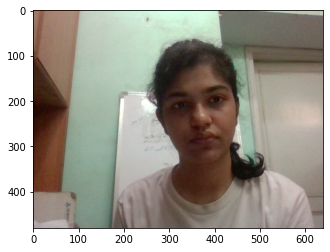

In [12]:
plt.imshow(cv2.cvtColor(imgs1[], cv2.COLOR_BGR2RGB))

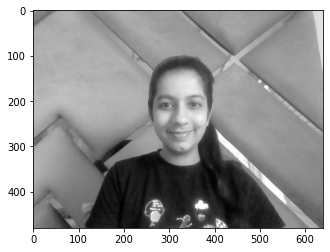

In [408]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap=plt.cm.gray)

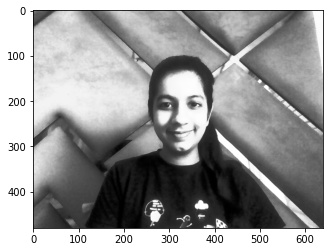

In [415]:
image = cv2.equalizeHist(gray)
plt.imshow(image, cmap=plt.cm.gray)

In [417]:
lStart, lEnd

(42, 48)